# Question 1
Min-A Cho Zeno

In [17]:
!pip install torch

In [18]:
import numpy as np

# Import libraries
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
"""
Question 1:

Given two sets of coordinates in 3D space, X : [Nx, 3] and Y : [Ny, 3],
return the subset of coordinates in X that are within a cutoff distance
d_max to any coordinate in Y.
"""

import math
import torch

from torch import Tensor
from typing import Tuple


def generate_example_input() -> Tuple[Tensor, Tensor, float]:
    t = torch.linspace(0, 1, 57)
    #t=torch.linspace(0,1,5)

    x = torch.stack([
        5 * (2 * math.pi * t).cos() + 0.1 * torch.randn_like(t),
        5 * (2 * math.pi * t).sin() + 0.1 * torch.randn_like(t),
        0.1 * torch.randn_like(t),
    ], dim=-1)

    y = torch.randn(14, 3) + torch.tensor([[3.8, 3.8, -1.0]])
    #y = torch.randn(7,3) + torch.tensor([[3.8,3.8,-1.0]])

    dmax = 2.5

    return (x, y, dmax)

Generate my samples.

In [20]:
x_list,y_list,dmax = generate_example_input()

Using numpy, check that I'm calculating distances correctly using PyTorch.

In [21]:
x0 = x_list[0].numpy()
y0 = y_list[0].numpy()

dist = np.linalg.norm(x0-y0)
print(dist)
print(dist**2)

3.484138
12.139217686192069


In [22]:
torch.dot(x_list[0]-y_list[0], x_list[0]-y_list[0])

tensor(12.1392)

Now try plotting the sample points that were generated using matplotlib.

In [23]:
x1=x_list[:,0]
x2=x_list[:,1]
x3=x_list[:,2]

y1=y_list[:,0]
y2=y_list[:,1]
y3=y_list[:,2]

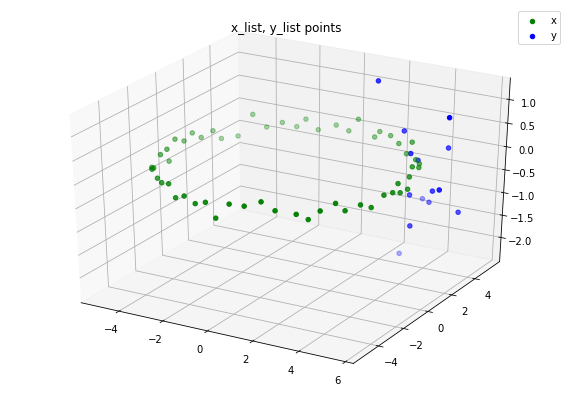

In [24]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ='3d')
 
# Create plot
ax.scatter3D(x1, x2, x3, color = 'g', label='x')
ax.scatter3D(y1,y2,y3, color='b', label='y')
ax.legend()
plt.title("x_list, y_list points")
 
# Show plot
plt.show()

**1. Brute force method first.**

Try computing the distance between each x_list, y_list (x,y) point pair. This is obviously not the most effective way to solve this problem because if dmax were very small, the plot shows us that only a few select green points (x) are near the blue cluster (y). This means, depending on the value of dmax, the brute force algorithm becomes more and more ineffective when dmax is small because you wouldn't want to compare every pair of x and y.

In [25]:
def points_within_dmax(x_list, y_list, dmax):
    """
    Given two sets of coordinates in 3D space, X : [Nx, 3] and Y : [Ny, 3],
    return the subset of coordinates in X that are within a cutoff distance
    d_max to any coordinate in Y.
    """
    all_combos = ((x, y) for x in x_list for y in y_list)
    close_x = []
    for x,y in all_combos:
        # Compute distance between x and y
        dist = math.sqrt(torch.dot(x-y,x-y).item())

        # Check condition
        if dist <= dmax:
            close_x.append(x)
    return set(close_x)

points_within_dmax(x_list, y_list, dmax)

{tensor([ 1.2966,  4.7440, -0.0221]),
 tensor([ 3.1875,  3.8513, -0.0734]),
 tensor([ 3.9956e+00,  3.0729e+00, -2.4648e-03]),
 tensor([ 4.3323,  2.7442, -0.0050]),
 tensor([ 4.5122,  2.3593, -0.0078]),
 tensor([ 5.0237,  0.4978, -0.1147]),
 tensor([-0.0115,  5.0180, -0.0477]),
 tensor([-0.6306,  5.1048,  0.0085]),
 tensor([0.4493, 4.9431, 0.2552]),
 tensor([1.4848, 4.8101, 0.1012]),
 tensor([2.0698, 4.6175, 0.0956]),
 tensor([2.7046, 4.1137, 0.0614]),
 tensor([3.6291, 3.4465, 0.2784]),
 tensor([4.5242, 1.7888, 0.1003]),
 tensor([4.7598, 1.1194, 0.0170])}

Now we want to improve upon the brute force method, perhaps using machine learning.

Brain-storming idea: One way to do this might be to use k-means clustering where k=2.

**2. K means clustering**


In [26]:
!pip install kmeans_pytorch

In [27]:
from kmeans_pytorch import kmeans, kmeans_predict

In [28]:
# Combine x_list and y_list into one PyTorch matrix/tensor
combined = torch.cat((x_list, y_list), 0)

cluster_ids, cluster_centers = kmeans(X=combined,
                                      num_clusters=2,
                                      distance='euclidean',
                                      tol=0.0001)

c1=combined[:,0]
c2=combined[:,1]
c3=combined[:,2]

running k-means on cpu..


[running kmeans]: 3it [00:00, 205.05it/s, center_shift=0.000000, iteration=3, tol=0.000100]


Now we can try plotting the classifications.

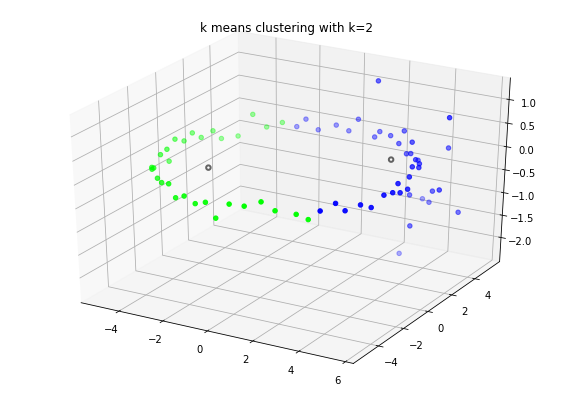

In [29]:
plt.figure(figsize=(10, 7))
ax = plt.axes(projection ='3d')

# Create plot
ax.scatter3D(c1, c2, c3, c=cluster_ids, cmap='brg')
ax.scatter(
    cluster_centers[:,0], cluster_centers[:,1],
    c='white',
    alpha=0.6,
    edgecolors='black',
    linewidths=2
)
plt.title("k means clustering with k=2")

# Show plot
plt.show()

From the plot, we can see that approximately half of the inital x points in x_list are closer to y. So, the idea is to take only the x points that have been classified similar to y, and do the brute force on those points to check the dmax condition.

The following function will do the K means inside of the function but first using a training sample of x, so that we don't just re-use the same data in training as in testing. Then it will predict using the original x_list.

running k-means on cpu..


[running kmeans]: 3it [00:00, 313.49it/s, center_shift=0.000000, iteration=3, tol=0.000100]


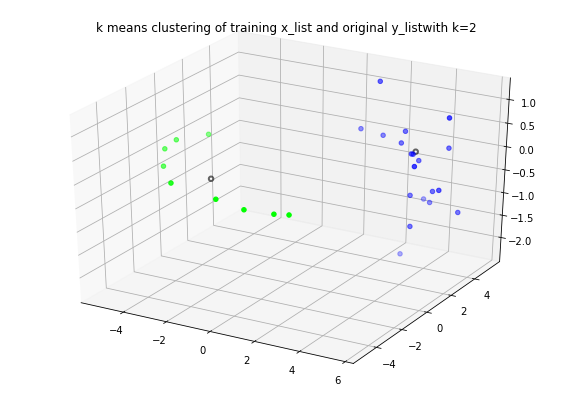

predicting on cpu..


{tensor([ 1.2966,  4.7440, -0.0221]),
 tensor([ 3.1875,  3.8513, -0.0734]),
 tensor([ 3.9956e+00,  3.0729e+00, -2.4648e-03]),
 tensor([ 4.3323,  2.7442, -0.0050]),
 tensor([ 4.5122,  2.3593, -0.0078]),
 tensor([ 5.0237,  0.4978, -0.1147]),
 tensor([-0.0115,  5.0180, -0.0477]),
 tensor([-0.6306,  5.1048,  0.0085]),
 tensor([0.4493, 4.9431, 0.2552]),
 tensor([1.4848, 4.8101, 0.1012]),
 tensor([2.0698, 4.6175, 0.0956]),
 tensor([2.7046, 4.1137, 0.0614]),
 tensor([3.6291, 3.4465, 0.2784]),
 tensor([4.5242, 1.7888, 0.1003]),
 tensor([4.7598, 1.1194, 0.0170])}

In [30]:
def x_points_similar_y(x_list, y_list, dmax):
    """
    Given two sets of coordinates in 3D space, X : [Nx, 3] and Y : [Ny, 3],
    ATTEMPTS to return the subset of coordinates in X that are within a cutoff
    distance d_max to any coordinate in Y.
    """

    # First, generate a separate training x_list for k-means
    x_list_tr,y_list_tr,dmax_tr = generate_example_input()

    # We want nearly balanced clusters. So combine samples from x_list after it
    # has been shuffled first
    idx = torch.randperm(x_list_tr.shape[0])
    shuffled_x_list_tr = x_list_tr[idx].view(x_list_tr.size())
    x_list_tr = shuffled_x_list_tr[:len(y_list)]

    # Combine x_list_tr and the original y_list and use k-means to classify
    # into 2 categories
    combined = torch.cat((x_list_tr, y_list), 0)
    cluster_ids, cluster_centers = kmeans(X=combined, num_clusters=2,
                                          distance='euclidean')

    # Plot clustering for x_list_tr and y_list
    c1=combined[:,0]
    c2=combined[:,1]
    c3=combined[:,2]

    plt.figure(figsize=(10, 7))
    ax = plt.axes(projection ='3d')

    # Create plot
    ax.scatter3D(c1, c2, c3, c=cluster_ids, cmap='brg')
    ax.scatter(
        cluster_centers[:,0], cluster_centers[:,1],
        c='white',
        alpha=0.6,
        edgecolors='black',
        linewidths=2
    )
    plt.title("k means clustering of training x_list and original y_list" \
              "with k=2")

    # Show plot
    plt.show()

    def determine_y_cluster_id(combined, cluster_ids):
        # Because the points in y could have been classified differently,
        # we need to see what the majority of them were classified as.
        # For our specific example distribution, they should all be
        # classified in the same cluster...
        target_cluster_id_0 = 0
        target_cluster_id_1 = 1
        for tensor, cluster_id in zip(combined, cluster_ids):
            if tensor in y_list:
                target_cluster_id = cluster_id.item()
                if target_cluster_id == 0:
                    target_cluster_id_0 += 1
                else:
                    target_cluster_id_1 += 1
        return 0 if target_cluster_id_0 > target_cluster_id_1 else 1

    # Determine the cluster_id for points clustered with y_list.
    y_cluster_id = determine_y_cluster_id(combined, cluster_ids)

    # Predict cluster ids for all x in our original x_list
    # These points are NOT the same as the points used in training!!
    cluster_ids_x = kmeans_predict(x_list, cluster_centers, 'euclidean')
    
    # Find x classified same as majority points in y_list
    similar_x = []
    for x,cluster_id in zip(x_list, cluster_ids_x):
        if cluster_id.item() == y_cluster_id:
          similar_x.append(x)
    
    # Now we have a smaller list of x to check the dmax condition
    return points_within_dmax(similar_x, y_list, dmax)

x_points_similar_y(x_list, y_list, dmax)

Now, although we get the same answer there are some caveats/warnings for this method.

If x_list and y_list were distributed differently and overlapping each other quite a bit -- we would run into problems from the get-go because all the points of y_list might not be clustered into the same label. In that case, we will miss all those x's that are clustered the opposite (but still within dmax of points in y_list). So the method above is specific to the distribution of x_list and y_list given in generate_example_input().

**3. PyTorch Functionality**

We will assume that the number of atoms is small enough that we can compute the distances between all pairs. In this case, there are one or two PyTorch functions we can use.

In [31]:
def points_within_dmax_pytorch(x_list, y_list, dmax):
    """
    Given two sets of coordinates in 3D space, X : [Nx, 3] and Y : [Ny, 3],
    the function returns the subset of coordinates in X that are within a cutoff
    distance d_max to any coordinate in Y.
    """

    # First, compute all pairwise distances between x_list and y_list
    all_distances = torch.cdist(x_list, y_list, p=2)

    close_x = []
    
    # Each tensor/row in all_distances contains distances from an x in x_list to
    # all y in y_list. All we need to do is look at the min and compare to dmax
    for i, tensor in enumerate(all_distances):
        min_dist = min(tensor).item()
        if min_dist <= dmax: # We want to store the coordinates of x
            close_x.append(x_list[i])
    return close_x

points_within_dmax_pytorch(x_list, y_list, dmax)

[tensor([ 5.0237,  0.4978, -0.1147]),
 tensor([4.7598, 1.1194, 0.0170]),
 tensor([4.5242, 1.7888, 0.1003]),
 tensor([ 4.5122,  2.3593, -0.0078]),
 tensor([ 4.3323,  2.7442, -0.0050]),
 tensor([ 3.9956e+00,  3.0729e+00, -2.4648e-03]),
 tensor([3.6291, 3.4465, 0.2784]),
 tensor([ 3.1875,  3.8513, -0.0734]),
 tensor([2.7046, 4.1137, 0.0614]),
 tensor([2.0698, 4.6175, 0.0956]),
 tensor([1.4848, 4.8101, 0.1012]),
 tensor([ 1.2966,  4.7440, -0.0221]),
 tensor([0.4493, 4.9431, 0.2552]),
 tensor([-0.0115,  5.0180, -0.0477]),
 tensor([-0.6306,  5.1048,  0.0085])]

Now we compare this solution to the brute-force method to double-check.

In [32]:
points_within_dmax(x_list, y_list, dmax)

{tensor([ 1.2966,  4.7440, -0.0221]),
 tensor([ 3.1875,  3.8513, -0.0734]),
 tensor([ 3.9956e+00,  3.0729e+00, -2.4648e-03]),
 tensor([ 4.3323,  2.7442, -0.0050]),
 tensor([ 4.5122,  2.3593, -0.0078]),
 tensor([ 5.0237,  0.4978, -0.1147]),
 tensor([-0.0115,  5.0180, -0.0477]),
 tensor([-0.6306,  5.1048,  0.0085]),
 tensor([0.4493, 4.9431, 0.2552]),
 tensor([1.4848, 4.8101, 0.1012]),
 tensor([2.0698, 4.6175, 0.0956]),
 tensor([2.7046, 4.1137, 0.0614]),
 tensor([3.6291, 3.4465, 0.2784]),
 tensor([4.5242, 1.7888, 0.1003]),
 tensor([4.7598, 1.1194, 0.0170])}

They are indeed the same!